In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchrl
import matplotlib.pyplot as plt
from tensordict import TensorDict
from flipper_training.environment.env import Env
from flipper_training.configs import WorldConfig, RobotModelConfig, PhysicsEngineConfig

In [3]:
num_robots = 1

In [ ]:
from flipper_training.heightmaps.trunks import FixedTrunkHeightmapGenerator

# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
heighmap_gen = FixedTrunkHeightmapGenerator(normal_angle=0.0, trunk_height=0.3, dist_from_origin=0.0, trunk_deadzone_width=0.5, trunk_width=1.0)
x_grid, y_grid, z_grid, extras = heighmap_gen(grid_res, max_coord, num_robots)

In [5]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(x_grid[0], y_grid[0], z_grid[0])

In [6]:
device = "cpu"

In [7]:
# Instatiate the physics config
robot_model = RobotModelConfig(kind="marv", points_per_driving_part=256, points_per_body=512)
world_config = WorldConfig(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=30000,
    grid_extras=extras,
    k_friction_lat=0.5,
    k_friction_lon=1.0,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots, damping_alpha=5.0)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.010_dp256b_512_whl0.02_trck0.05_87af005b105b87477786d1a02b8cbdaf0ed9653f5e1abb271ea4cc77b78aaa52
driving_direction: torch.Size([3])
body_bbox: torch.Size([6])
driving_part_bboxes: torch.Size([4, 6])
driving_part_masses: torch.Size([4])
driving_part_pivot_signs: torch.Size([4])
joint_positions: torch.Size([4, 3])
joint_limits: torch.Size([2, 4])
joint_max_pivot_vels: torch.Size([4])
driving_part_points: torch.Size([4, 256, 3])
driving_part_inertias: torch.Size([4, 3, 3])
driving_part_cogs: torch.Size([4, 3])
body_points: torch.Size([512, 3])
body_inertia: torch.Size([3, 3])
body_cog: torch.Size([3])
thrust_directions: torch.Size([4, 256, 3])
joint_local_driving_part_pts: torch.Size([4, 256, 3])
joint_local_driving_part_cogs: torch.Size([4, 3])
RobotModelConfig for marv
Total mass: 67.8


In [8]:
from flipper_training.observations import *
from functools import partial

obs = {
    "perception": partial(Heightmap, percep_shape=(128, 128), percep_extent=(1.0, 1.0, -1.0, -1.0)),
    "observation": partial(RobotStateVector),
}

obs["perception"]

functools.partial(<class 'flipper_training.observations.heightmap.Heightmap'>, percep_shape=(128, 128), percep_extent=(1.0, 1.0, -1.0, -1.0))

In [9]:
from flipper_training.rl_rewards.rewards import Goal

reward = Goal(1000, -1000, 2.0, exp=1)

In [42]:
from flipper_training.rl_objectives.trunk_crossing import FixedTrunkCrossing

objective = FixedTrunkCrossing(
    physics_config=physics_config,
    robot_model=robot_model,
    world_config=world_config,
    device=device,
    rng=torch.manual_seed(0),
    **{
        "start_x_y_z": torch.tensor([-2.0, 0.0, 0.1]),
        "goal_x_y_z": torch.tensor([2.0, 0.0, 0.1]),
        "goal_reached_threshold": 0.05,
        "max_feasible_pitch": torch.deg2rad(torch.tensor(70.0)),
        "iteration_limit": 500,
    },
)

In [43]:
torch_env = Env(
    objective,
    reward,
    obs,
    world_config,
    physics_config,
    robot_model,
    device,
    differentiable=False,
    batch_size=[num_robots],
    engine_compile_opts={
        "max-autotune": True,
        "triton.cudagraphs": True,
        "coordinate_descent_tuning": True,
        "correctness_iters": 100,
        "benchmark_iters": 1000,
        "atol": 10,
        "rtol": 0,
    },
)

In [44]:
torchrl.envs.utils.check_env_specs(torch_env)

2025-03-26 00:38:00,596 [torchrl][INFO] check_env_specs succeeded!


In [45]:
torch_env.reset(reset_all=True)
torch_env.visualize_curr_state()

In [46]:
from collections import deque
from flipper_training.engine.engine_state import vectorize_iter_of_states

In [47]:
ROBOT_IDX = 0

In [48]:
import time

Simulation time: 1.80650 seconds (0.00361 seconds per step)


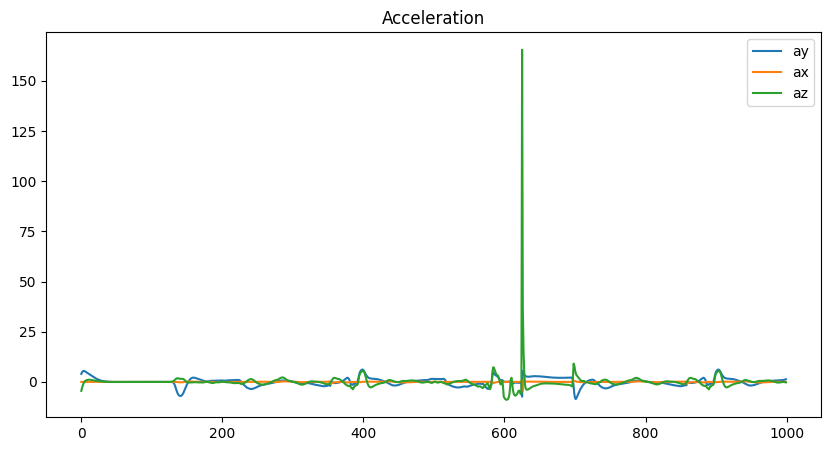

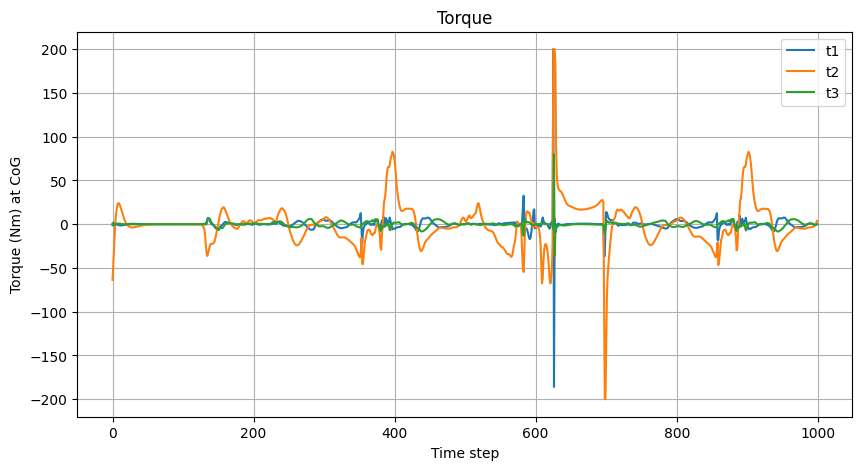

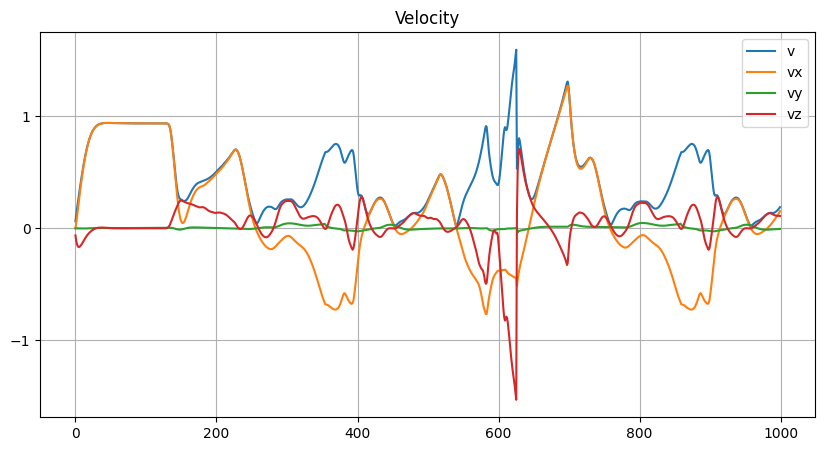

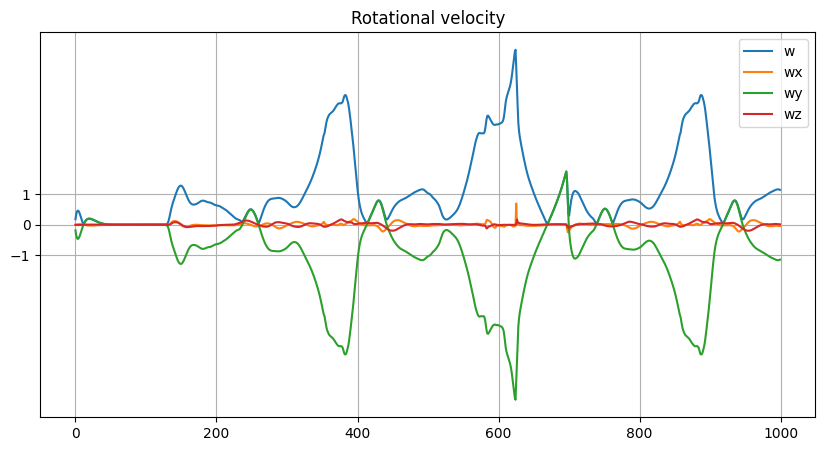

In [57]:
states = deque()
dstates = deque()
auxs = deque()

# Controls
speed = 1.0  # m/s forward
flipper_controls = torch.full((robot_model.num_driving_parts,), 0.0)
control_vec = torch.cat([torch.full((4,), speed), flipper_controls]).unsqueeze(0).repeat(num_robots, 1)
control_td = TensorDict({"action": control_vec}, batch_size=num_robots)

torch_env.reset(reset_all=True)

start_time = time.time()
for _ in range(1000):
    o = torch_env.step(control_td)
    states.append(torch_env.state.clone())
    dstates.append(torch_env.last_step_der.clone())
    auxs.append(torch_env.last_step_aux_info.clone())
dur = time.time() - start_time
print(f"Simulation time: {dur:.5f} seconds ({dur / 500:.5f} seconds per step)")

dstates_vec = vectorize_iter_of_states(dstates)
auxs_vec = vectorize_iter_of_states(auxs)
states_vec = vectorize_iter_of_states(states)

# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Acceleration")
plt.plot(ay, label="ay")
plt.plot(ax, label="ax")
plt.plot(az, label="az")
plt.legend()
plt.show()

# Plot components of torque
t1, t2, t3 = auxs_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Torque")
plt.plot(t1, label="t1")
plt.plot(t2, label="t2")
plt.plot(t3, label="t3")
plt.grid()
plt.xlabel("Time step")
plt.ylabel("Torque (Nm) at CoG")
plt.legend()
plt.show()

# Plot components of velocity
v = dstates_vec.xd[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Velocity")
plt.plot((v**2).sum(-1) ** 0.5, label="v")
plt.plot(v[:, 0], label="vx")
plt.plot(v[:, 1], label="vy")
plt.plot(v[:, 2], label="vz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

# Plot components of rotational velocity
w = states_vec.omega[:, ROBOT_IDX].cpu().numpy()
plt.figure(figsize=(10, 5))
plt.title("Rotational velocity")
plt.plot((w**2).sum(-1) ** 0.5, label="w")
plt.plot(w[:, 0], label="wx")
plt.plot(w[:, 1], label="wy")
plt.plot(w[:, 2], label="wz")
plt.yticks([-1, 0, 1])
plt.legend()
plt.grid()
plt.show()

torch_env.visualize_curr_state()

In [50]:
from flipper_training.vis.animator import animate_trajectory

ani = animate_trajectory(
    world_config,
    physics_config,
    states,
    auxs,
    ROBOT_IDX,
    show_xd_points=False,
    show_cog_coords=False,
    show_friction_forces=True,
    show_spring_forces=True,
    show_act_forces=False,
)